# Name: Aadit Harshal Baldha
# Batch: Fall 2024 (2nd Sem)
# CWID: 20029691

## Topic: ML: Fundamentals and Applications Project Individual Work for Cluster Group #0

### 3.3 Building the Training Model

#### 3.3.1 Creating the Classification Model

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Fitting 5 folds for each of 72 candidates, totalling 360 fits


c:\Users\aadit\Anaconda\envs\AaHB_CS556B_Env\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:49:43] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
              precision    recall  f1-score   support

           0       0.96      0.95      0.95       311
           1       0.95      0.96      0.95       470
           2       0.96      0.95      0.96       381

    accuracy                           0.95      1162
   macro avg       0.96      0.95      0.95      1162
weighted avg       0.95      0.95      0.95      1162



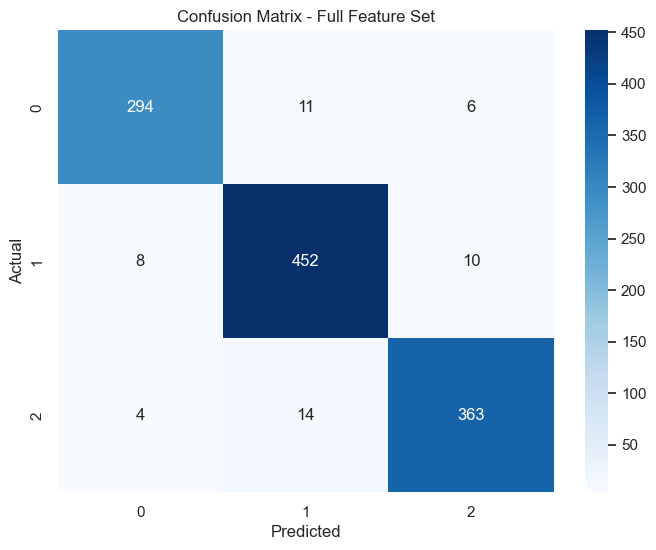


Top 28 feature dataset saved to output/top_28_features.csv


In [18]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

clustered_df = pd.read_csv('output/clustered_data.csv')
X_full = clustered_df.drop(columns=['Cluster'])
y = clustered_df['Cluster']

X_train, X_test, y_train, y_test = train_test_split(
    X_full, y, test_size=0.2, stratify=y, random_state=42
)

xgb_model = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=len(y.unique()),
    eval_metric='mlogloss',
    use_label_encoder=False,
    random_state=42
)

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(xgb_model, param_grid, scoring='accuracy', cv=cv, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

y_pred = grid_search.best_estimator_.predict(X_test)
print("Best Parameters:", grid_search.best_params_)
print(classification_report(y_test, y_pred))

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Full Feature Set")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

feature_importances = pd.Series(
    grid_search.best_estimator_.feature_importances_,
    index=X_full.columns
).sort_values(ascending=False)
feature_importances.to_csv("output/feature_importances_full.csv")

top_n = 28  
top_features = feature_importances.head(top_n).index.tolist()

top_n_df = clustered_df[top_features + ['Cluster','Bankrupt?']]
top_n_df.to_csv(f"output/top_{top_n}_features.csv", index=False)
print(f"\nTop {top_n} feature dataset saved to output/top_{top_n}_features.csv")


<Figure size 1200x800 with 0 Axes>

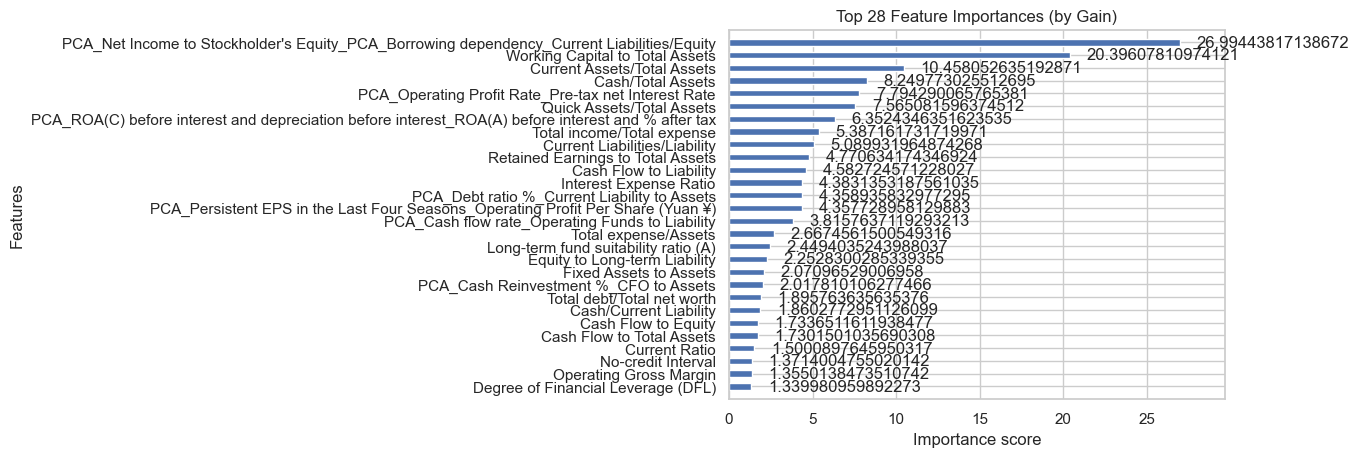

In [19]:
import matplotlib.pyplot as plt
import xgboost as xgb

# Access the trained model
best_model = grid_search.best_estimator_

# Plot top N feature importances by gain
plt.figure(figsize=(12, 8))
xgb.plot_importance(
    best_model,
    importance_type='gain',  # or 'weight', 'cover', 'total_gain'
    max_num_features=top_n,
    height=0.5
)
plt.title(f'Top {top_n} Feature Importances (by Gain)')
plt.show()


Fitting 5 folds for each of 72 candidates, totalling 360 fits


c:\Users\aadit\Anaconda\envs\AaHB_CS556B_Env\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:52:19] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best Parameters (Reduced): {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
              precision    recall  f1-score   support

           0       0.96      0.95      0.95       311
           1       0.94      0.96      0.95       470
           2       0.96      0.94      0.95       381

    accuracy                           0.95      1162
   macro avg       0.95      0.95      0.95      1162
weighted avg       0.95      0.95      0.95      1162



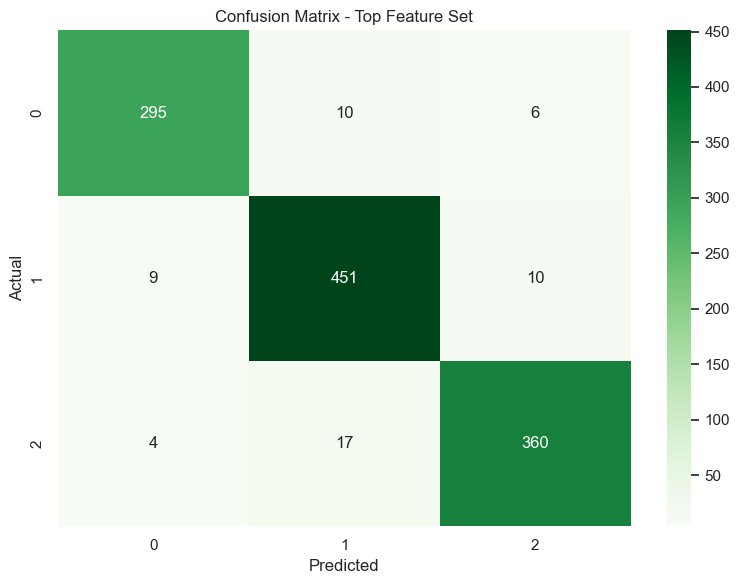


Cross-Validation Results:
Mean Accuracy: 0.9533 ± 0.0040
Mean Precision (Macro): 0.9544 ± 0.0038
Mean Recall (Macro): 0.9531 ± 0.0046
Mean F1-score (Macro): 0.9537 ± 0.0042

✅ Full dataframe with predictions saved to: output/top_28_features_with_predictions.csv
Saved predicted cluster 0 to output/predicted_cluster_0.csv
Saved predicted cluster 1 to output/predicted_cluster_1.csv
Saved predicted cluster 2 to output/predicted_cluster_2.csv


In [20]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_validate
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Parameters
top_n = 28  # Set your desired number of features

# Ensure output directory exists
os.makedirs("output", exist_ok=True)

# Load reduced feature set
reduced_df = pd.read_csv(f"output/top_{top_n}_features.csv", index_col=0)
X_reduced = reduced_df.drop(columns=['Cluster'])
y = reduced_df['Cluster']

# Train-test split
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(
    X_reduced, y, test_size=0.2, stratify=y, random_state=42
)

# Model
xgb_reduced = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=len(y.unique()),
    eval_metric='mlogloss',
    use_label_encoder=False,
    random_state=42
)

# Hyperparameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Grid Search
grid_search_r = GridSearchCV(xgb_reduced, param_grid, scoring='accuracy', cv=cv, n_jobs=-1, verbose=1)
grid_search_r.fit(X_train_r, y_train_r)

# Evaluation
y_pred_r_test = grid_search_r.best_estimator_.predict(X_test_r)
print("Best Parameters (Reduced):", grid_search_r.best_params_)
print(classification_report(y_test_r, y_pred_r_test))

# Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test_r, y_pred_r_test), annot=True, fmt='d', cmap='Greens')
plt.title("Confusion Matrix - Top Feature Set")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# Cross-validation performance
scoring = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']
cv_results_r = cross_validate(
    grid_search_r.best_estimator_, X_reduced, y,
    cv=cv, scoring=scoring, n_jobs=-1
)

print("\nCross-Validation Results:")
print(f"Mean Accuracy: {cv_results_r['test_accuracy'].mean():.4f} ± {cv_results_r['test_accuracy'].std():.4f}")
print(f"Mean Precision (Macro): {cv_results_r['test_precision_macro'].mean():.4f} ± {cv_results_r['test_precision_macro'].std():.4f}")
print(f"Mean Recall (Macro): {cv_results_r['test_recall_macro'].mean():.4f} ± {cv_results_r['test_recall_macro'].std():.4f}")
print(f"Mean F1-score (Macro): {cv_results_r['test_f1_macro'].mean():.4f} ± {cv_results_r['test_f1_macro'].std():.4f}")

# Predict on entire dataset to get predictions for all rows
y_pred_all = grid_search_r.best_estimator_.predict(X_reduced)

# Append predictions to DataFrame
reduced_df['Predicted_Cluster'] = y_pred_all

# Save full DataFrame with predictions
output_full_path = f"output/top_{top_n}_features_with_predictions.csv"
reduced_df.to_csv(output_full_path)
print(f"\n✅ Full dataframe with predictions saved to: {output_full_path}")

# Split and save by predicted clusters
for cluster_label, group in reduced_df.groupby('Predicted_Cluster'):
    path = f"output/predicted_cluster_{int(cluster_label)}.csv"
    group.to_csv(path)
    print(f"Saved predicted cluster {int(cluster_label)} to {path}")


C:\Users\aadit\AppData\Local\Temp\ipykernel_26632\3051926841.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, x='Bankrupt?', palette='Set2')


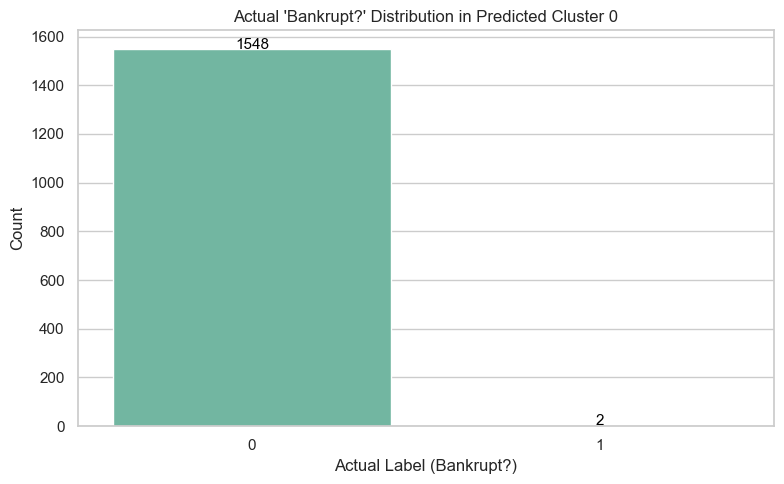

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os

# Set consistent style
sns.set(style="whitegrid")

# Get all predicted cluster files
cluster_files = sorted(glob.glob("output/predicted_cluster_0.csv"))

# Plot for each predicted cluster file with frequency labels
for file in cluster_files:
    df = pd.read_csv(file, index_col=0)
    cluster_label = os.path.basename(file).split("_")[-1].split(".")[0]  # Extract cluster number

    plt.figure(figsize=(8, 5))
    ax = sns.countplot(data=df, x='Bankrupt?', palette='Set2')

    # Add counts above bars
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width() / 2., height + 1,
                f'{int(height)}', ha='center', fontsize=11, color='black')

    plt.title(f"Actual 'Bankrupt?' Distribution in Predicted Cluster {cluster_label}")
    plt.xlabel("Actual Label (Bankrupt?)")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()


#### 3.3.2 Building the Stacking Model

In [22]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline


In [23]:
# Separate features and labels
predicted_cluster_df=pd.read_csv('output/predicted_cluster_0.csv')
X = predicted_cluster_df.drop(columns=['Bankrupt?'])
y = predicted_cluster_df['Bankrupt?']


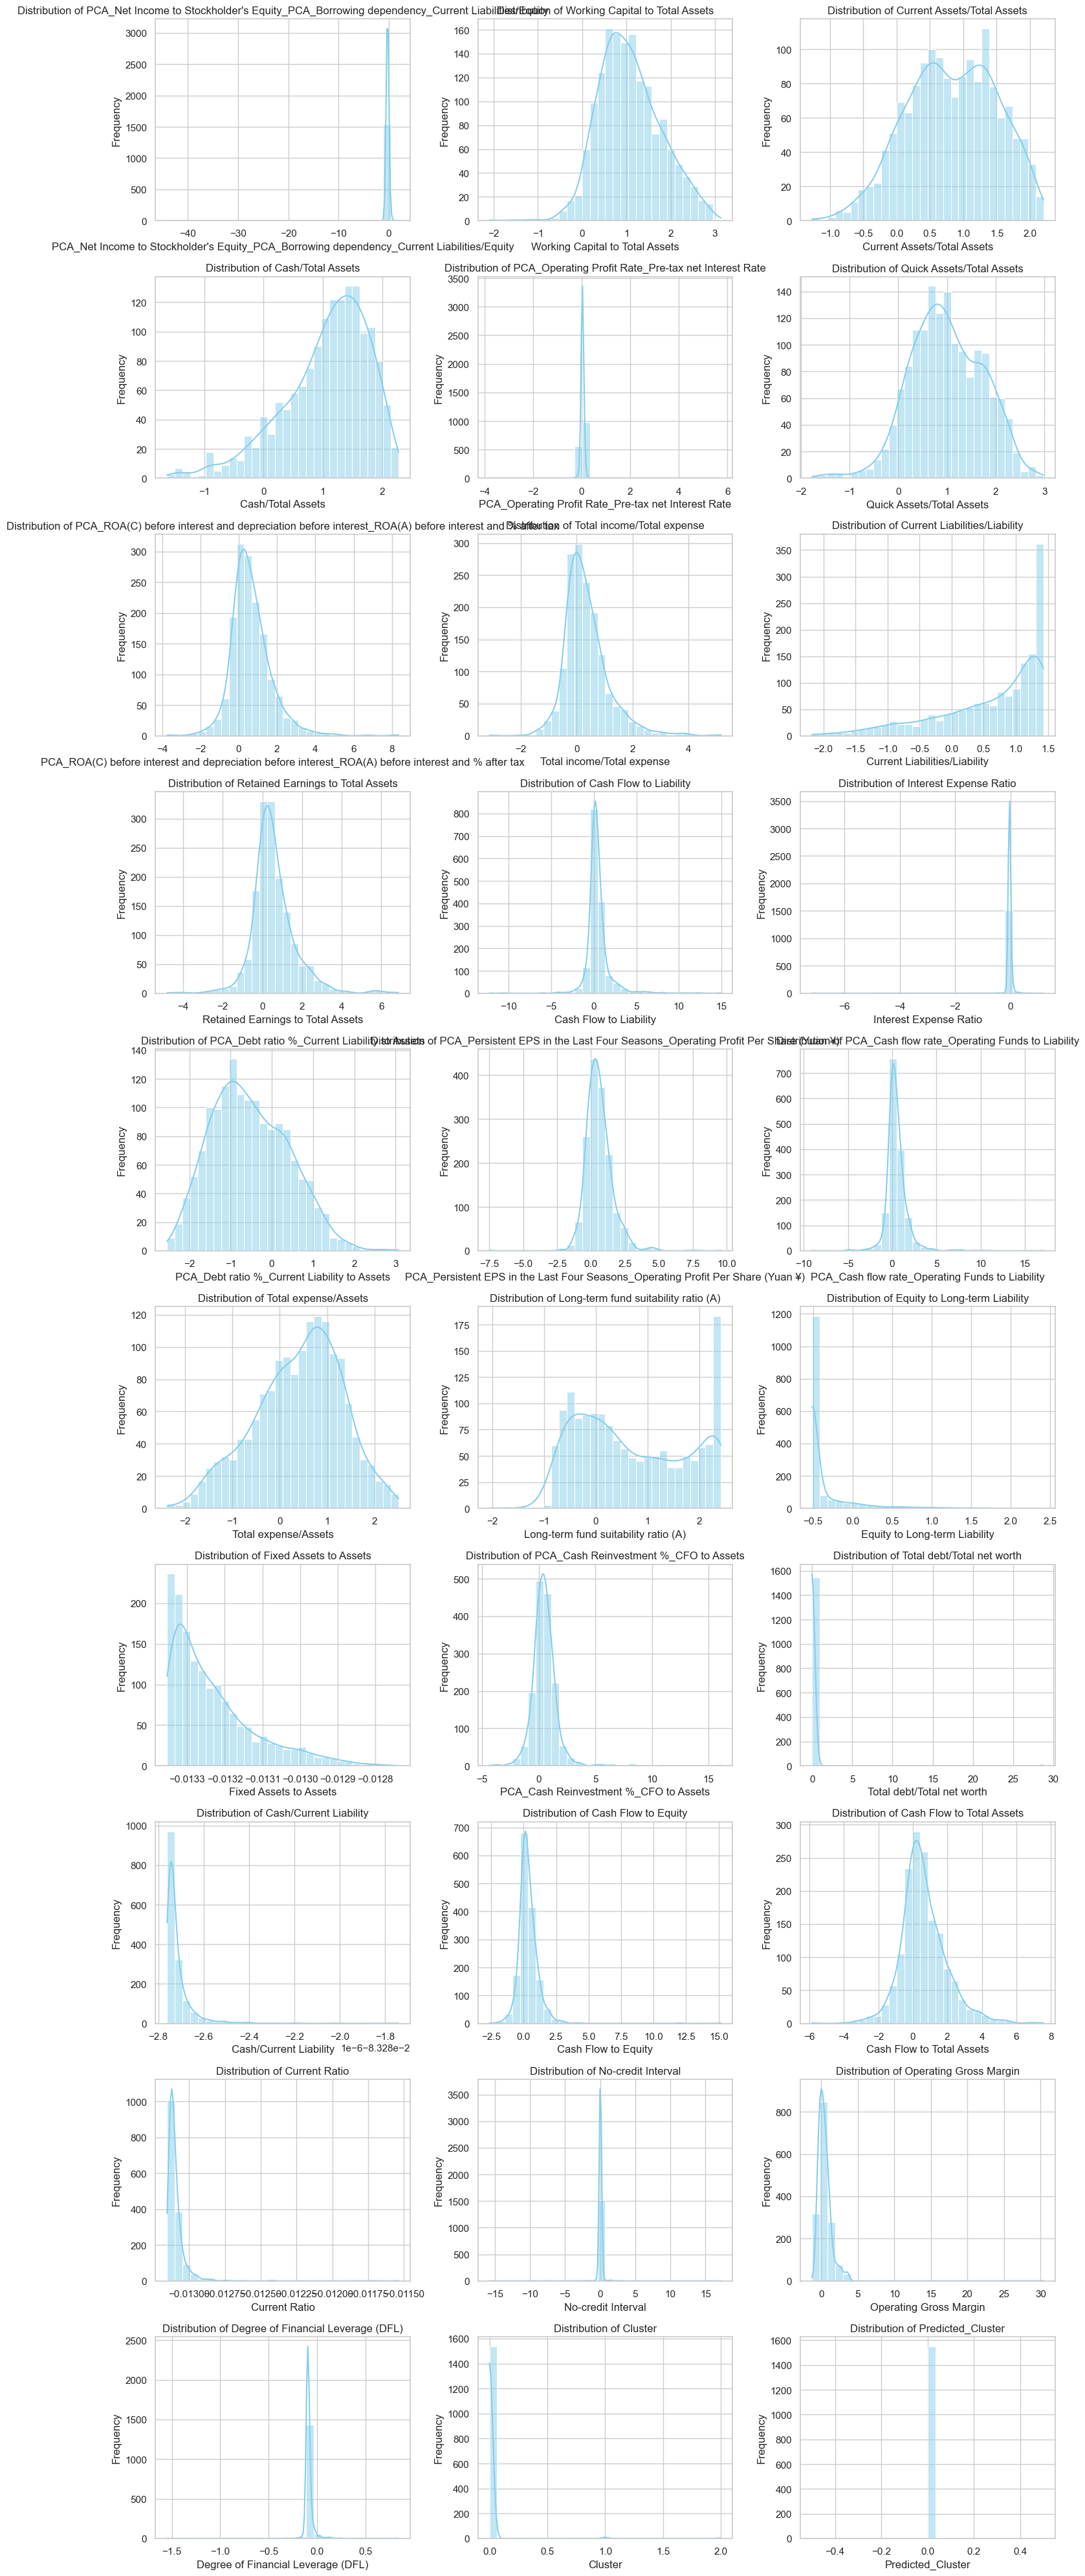

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the plotting style
sns.set(style='whitegrid')

# Create subplots
num_features = X.shape[1]
cols = 3  # Number of columns in the subplot grid
rows = (num_features + cols - 1) // cols  # Calculate required rows

plt.figure(figsize=(cols * 5, rows * 4))

for i, col in enumerate(X.columns, 1):
    plt.subplot(rows, cols, i)
    sns.histplot(X[col], kde=True, bins=30, color='skyblue')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


In [28]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import precision_recall_curve, classification_report
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# === Load data and augment ===
columns_to_drop=[
'Cluster',
'Predicted_Cluster',
'PCA_Net Income to Stockholder\'s Equity_PCA_Borrowing dependency_Current Liabilities/Equity',
'Interest Expense Ratio',
'Long-term fund suitability ratio (A)',
'Total debt/Total net worth',
'No-credit Interval',
'Degree of Financial Leverage (DFL)',
]
df = pd.read_csv("output/predicted_cluster_0.csv").drop(columns=columns_to_drop)

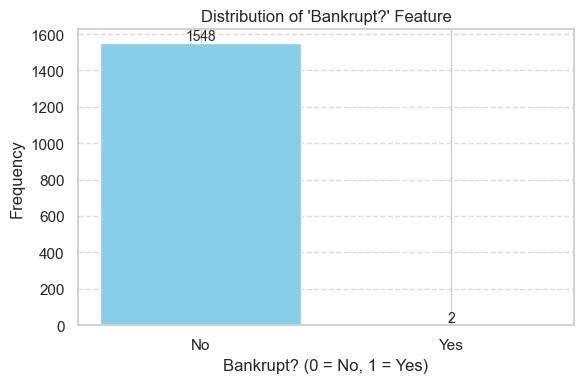

In [41]:
import matplotlib.pyplot as plt

# Count the frequency of each class (0 or 1)
bankrupt_counts = df['Bankrupt?'].value_counts().sort_index()

# Plot bar chart
plt.figure(figsize=(6, 4))
bars = plt.bar(bankrupt_counts.index.astype(str), bankrupt_counts.values, color=['skyblue', 'salmon'])
plt.title("Distribution of 'Bankrupt?' Feature")
plt.xlabel("Bankrupt? (0 = No, 1 = Yes)")
plt.ylabel("Frequency")
plt.xticks(ticks=[0, 1], labels=['No', 'Yes'], rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add counts on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 1, str(int(height)), 
             ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()



Top 5 Selected Features for Reduced Stacking Input:
['Current Liabilities/Liability', 'PCA_ROA(C) before interest and depreciation before interest_ROA(A) before interest and % after tax', 'PCA_Persistent EPS in the Last Four Seasons_Operating Profit Per Share (Yuan ¥)', 'Cash Flow to Equity', 'Total income/Total expense', 'Current Assets/Total Assets', 'PCA_Debt ratio %_Current Liability to Assets', 'Operating Gross Margin', 'Quick Assets/Total Assets', 'Cash/Current Liability']

=== Base Models Recall (Reduced Features) ===
Random Forest Recall: 1.0000
Gradient Boosting Recall: 1.0000
KNN Recall: 1.0000

Average Recall of Base Models: 1.0000

Stacking Meta-Model Recall: 1.0000

=== Classification Report (Threshold = 0.004) ===
              precision    recall  f1-score   support

           0       1.00      0.97      0.99      1548
           1       0.04      1.00      0.09         2

    accuracy                           0.97      1550
   macro avg       0.52      0.99      0.54

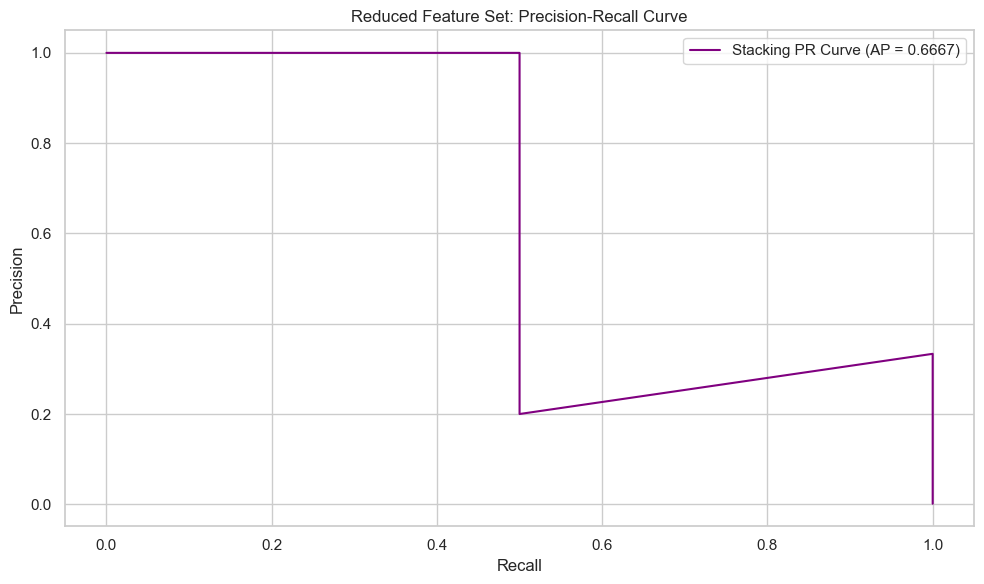

In [38]:
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import (
    classification_report, confusion_matrix, recall_score, average_precision_score,
    precision_recall_curve
)

# === Assume df is preloaded with 'Bankrupt?' as the target ===
X_orig = df.drop(columns=['Bankrupt?'])
y_orig = df['Bankrupt?']
custom_threshold = 0.004

# === Define base models ===
base_models_only = {
    'Random Forest': RandomForestClassifier(n_estimators=200, random_state=2, class_weight='balanced', max_depth=3),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=200, random_state=5),
    'KNN': KNeighborsClassifier(n_neighbors=15, weights='distance', metric='minkowski', p=2, n_jobs=-1)
}

# === Identify top features from each model ===
top_k = 15  # Number of features to extract from each model
feature_pool = []

for name, model in base_models_only.items():
    model.fit(X_orig, y_orig)
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
    else:
        result = permutation_importance(model, X_orig, y_orig, n_repeats=10, random_state=42, n_jobs=-1)
        importances = result.importances_mean
    top_features = X_orig.columns[np.argsort(importances)[-top_k:]]
    feature_pool.extend(top_features)

# === Select top 10 most frequently appearing features ===
feature_counts = Counter(feature_pool)
top_5_features = [feat for feat, _ in feature_counts.most_common(10)]

print("\nTop 5 Selected Features for Reduced Stacking Input:")
print(top_5_features)

# === Reduce dataset to selected features ===
X_reduced = X_orig[top_5_features]

# === Evaluate base models on reduced features ===
recalls_base = {}
print("\n=== Base Models Recall (Reduced Features) ===")
for name, model in base_models_only.items():
    model.fit(X_reduced, y_orig)
    y_pred = model.predict(X_reduced)
    recall = recall_score(y_orig, y_pred, zero_division=0)
    recalls_base[name] = recall
    print(f"{name} Recall: {recall:.4f}")

avg_base_recall = np.mean(list(recalls_base.values()))
print(f"\nAverage Recall of Base Models: {avg_base_recall:.4f}")

# === Stacking model using reduced features ===
stack_model = StackingClassifier(
    estimators=[
        ('rf', base_models_only['Random Forest']),
        ('gb', base_models_only['Gradient Boosting']),
        ('knn', base_models_only['KNN'])
    ],
    final_estimator=LogisticRegression(penalty='l2'),
    passthrough=True,
    cv=5,
    n_jobs=-1
)

stack_model.fit(X_reduced, y_orig)
risk_scores_stack = stack_model.predict_proba(X_reduced)[:, 1]
y_pred_stack = (risk_scores_stack >= custom_threshold).astype(int)
meta_model_recall = recall_score(y_orig, y_pred_stack, zero_division=0)

print(f"\nStacking Meta-Model Recall: {meta_model_recall:.4f}")

# === Classification Report ===
print(f"\n=== Classification Report (Threshold = {custom_threshold:.3f}) ===")
print(classification_report(y_orig, y_pred_stack, zero_division=0))
print("Confusion Matrix:")
print(confusion_matrix(y_orig, y_pred_stack))

# === Precision-Recall Curve ===
precision, recall, _ = precision_recall_curve(y_orig, risk_scores_stack)
avg_precision = average_precision_score(y_orig, risk_scores_stack)

plt.figure(figsize=(10, 6))
plt.plot(recall, precision, label=f'Stacking PR Curve (AP = {avg_precision:.4f})', color='purple')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Reduced Feature Set: Precision-Recall Curve")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
